# Dog Breed Classifier

## Convolutional Neural Networks

In this notebook, an algorithm is developed which accepts an user-supplied image file of a dog as input and provides an estimate of the dog's breed out of 133 options.

First, a convolutional neural network (CNN) is developed from scratch with random initialization. Later, a transfer learning is added to improve accuracy with bottleneck features taken from the pre-trained `ResNet-50` model. The model is created using [Keras 2.1.6](https://github.com/keras-team/keras/releases/tag/2.1.6) and 6680 dog images for training, 835 validation images, and 836 test images. Images [download](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).

### Steps

* Import Datasets
* Detect Dogs
* CNN from Scratch
* CNN using Transfer Learning
* Write Algorithm
* Test Algorithm

## Import Dataset

Importing dataset of dog images.

- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# Define function to load train, test, and validation datasets.
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# Load train, test, and validation datasets.
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# Load list of dog names.
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

print('{} dog categories; {} images, whereas {} training, {} validation, {} test.'
      .format(len(dog_names), 
              len(np.hstack([train_files, valid_files, test_files])),
              len(train_files),
              len(valid_files),
              len(test_files)
             ))

/Users/kai/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


133 dog categories; 8351 images, whereas 6680 training, 835 validation, 836 test.


## Detect Dogs

Using the pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images with weights that have been trained on [ImageNet](http://www.image-net.org/). ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

In [2]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

### Pre-process Data

When using TensorFlow as backend, Keras CNNs require a 4D array as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor.  Each image has three channels. Likewise, since a single image is processed, the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # Loads RGB image as PIL.Image.Image type.
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3).
    x = image.img_to_array(img)
    # Convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor.
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Predictions with ResNet-50

Additional processing to prepare the 4D tensor for ResNet-50: RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image; implemented in the imported function `preprocess_input`.

The `predict` method returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category; implemented in the `ResNet50_predict_labels` function below.

The `argmax` of the predicted probability vector, returns an integer corresponding to the model's predicted object class. The object category can be identified using this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [4]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # Returns prediction vector for image located at img_path.
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector

Categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, one needs to check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive). The functions returns `True` if a dog is detected in an image.

In [5]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

Testing the performance of the `dog_detector` function.

In [6]:
in_dogs_result = [dog_detector(i) for i in train_files[:100]]

print('{}% detected as dogs in dog dataset.'.format(np.sum(in_dogs_result)))

100% detected as dogs in dog dataset.


## CNN to Classify Dog Breeds (from Scratch)

Creating a CNN from scratch that classifies dog breeds without transfer learning. Assigning breeds to dogs from images is considered exceptionally challenging. Even a human would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel. However, it is not difficult to find other dog breed pairs with minimal inter-class variation, for instance, Curly-Coated Retrievers and American Water Spaniels.

Brittany | Welsh Springer Spaniel | Curly-Coated Retriever | American Water Spaniel
- | - | - | -
<img src="https://raw.githubusercontent.com/siebenrock/dog-breed-classifier/master/images/brittany.jpg" width="100"> | <img src="https://raw.githubusercontent.com/siebenrock/dog-breed-classifier/master/images/welsh_springer_spaniel.jpg" width="200"> | <img src="https://raw.githubusercontent.com/siebenrock/dog-breed-classifier/master/images/curly_coated_retriever.jpg" width="200"> | <img src="https://raw.githubusercontent.com/siebenrock/dog-breed-classifier/master/images/american_water_spaniel.jpg" width="200">

Random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-processing

Rescaling the images by dividing every pixel in every image by 255.

In [7]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 109.03it/s]


### Model Architecture

* Convolution layers detect regional patterns in the images
* Pooling layers reduce dimensionality of the arrays.
* Dropout layers prevent overfitting.

In [8]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32,(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.1))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 128)       73856     
__________

### Compiling the Model

In [9]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the Model

Starting the model training with 10 epochs, 6680 samples.

In [10]:
from keras.callbacks import ModelCheckpoint 

In [11]:
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 515s 77ms/step - loss: 4.8080 - acc: 0.0223 - val_loss: 4.6083 - val_acc: 0.0467

Epoch 00001: val_loss improved from inf to 4.60830, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
6680/6680 [==============================] - 506s 76ms/step - loss: 4.2184 - acc: 0.0939 - val_loss: 4.3778 - val_acc: 0.0647

Epoch 00002: val_loss improved from 4.60830 to 4.37781, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
6680/6680 [==============================] - 505s 76ms/step - loss: 3.0031 - acc: 0.3151 - val_loss: 4.7964 - val_acc: 0.0934

Epoch 00003: val_loss did not improve from 4.37781
Epoch 4/10
6680/6680 [==============================] - 506s 76ms/step - loss: 1.2619 - acc: 0.6883 - val_loss: 6.0779 - val_acc: 0.0934

Epoch 00004: val_loss did not improve from 4.37781
Epoch 5/10
6680/6680 [==============================] - 509s 76ms/step 

### Model with Best Validation Loss

In [12]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Testing the Model

In [13]:
# Index of predicted dog breed for each image in test set.
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# Report test accuracy.
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Accuracy: {:.2f}%'.format(test_accuracy))

Accuracy: 6.70%


The next steps add transfer learning to create a CNN that attains greatly improved accuracy.

## CNN to Classify Dog Breeds (using Transfer Learning)

Now using transfer learning to create a CNN that can identify dog breed from images. Thereby reducing training time without sacrificing accuracy. Bottleneck features taken from pre-trained `ResNet-50` model. `ResNet-50` bottleneck features [download](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz).

### Obtain Bottleneck Features

Extracting the bottleneck features corresponding to the train, test, and validation sets.

In [14]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
bottleneck_train = bottleneck_features['train']
bottleneck_valid = bottleneck_features['valid']
bottleneck_test = bottleneck_features['test']

In [15]:
bottleneck_train.shape[1:]

(1, 1, 2048)

### Model Architecture

Model uses the the pre-trained `ResNet-50` model as a fixed feature extractor, where the last convolutional output of `ResNet-50` is fed as input to our model. A global average pooling layer and a fully connected layer is added.

Average pooling layer is meant to reduce parameters by averaging multiple to reduce overfitting. Fully connected layer contains one node for each dog category and is equipped with a softmax to determine the most likely dog breed category.

In [16]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(1, 1, 2048)))
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


###  Compiling the Model

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Training the Model

In [18]:
epochs = 20

cp = ModelCheckpoint(filepath='saved_models/weights.best.from_resnet50.hdf5', verbose=1, save_best_only=True)

train = model.fit(bottleneck_train, train_targets, validation_data=(bottleneck_valid, valid_targets), epochs=epochs, 
          batch_size=20, callbacks=[cp], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 326us/step - loss: 1.6261 - acc: 0.5945 - val_loss: 0.8131 - val_acc: 0.7461

Epoch 00001: val_loss improved from inf to 0.81312, saving model to saved_models/weights.best.from_resnet50.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 193us/step - loss: 0.4345 - acc: 0.8662 - val_loss: 0.6856 - val_acc: 0.7868

Epoch 00002: val_loss improved from 0.81312 to 0.68562, saving model to saved_models/weights.best.from_resnet50.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 194us/step - loss: 0.2626 - acc: 0.9171 - val_loss: 0.6862 - val_acc: 0.7940

Epoch 00003: val_loss did not improve from 0.68562
Epoch 4/20
6680/6680 [==============================] - 1s 193us/step - loss: 0.1739 - acc: 0.9439 - val_loss: 0.6644 - val_acc: 0.8216

Epoch 00004: val_loss improved from 0.68562 to 0.66440, saving model to saved_models/weights.best.from_resnet50.hdf5
Epoch 5

In [19]:
import matplotlib.pyplot as plt

plt.figure().set_size_inches(15,3)
plt.subplot(1,2,2)
plt.plot(train.history['acc'],'b')
plt.plot(train.history['val_acc'],'r')
plt.ylabel('Accuracy')
plt.show()

### Loading the Model with the Best Validation Loss

In [20]:
model.load_weights('saved_models/weights.best.from_resnet50.hdf5')

### Testing the Model

Testing the CNN to see how well it identifies breeds within test dataset of dog images.

In [21]:
model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in bottleneck_test]
model_accuracy = 100*np.sum(np.array(model_predictions)==np.argmax(test_targets, axis=1))/len(model_predictions)

In [22]:
print('Res-Net model accuracy: {:.2f}%'.format(model_accuracy))

Res-Net model accuracy: 81.34%


### Accuracy Comparison

Accuracy of different pre-trained models:

* ResNet-50 model: 81%
* VGG19 model: 45% 
* Inception model: <30%

### Predicting Dog Breeds with the Model

Function that takes an image path as input and returns the predicted dog breed.

1. Extracting the bottleneck features from `ResNet-50`.
2. Supplying the bottleneck features as input to the model to return the predicted vector. `argmax` returns index.
3. Use the `dog_names` array to return the corresponding breed.

In [23]:
from keras.applications.resnet50 import ResNet50, preprocess_input

In [24]:
def check(img_path):
    bottleneck_feature = ResNet50(weights='imagenet', include_top=False).predict(
        preprocess_input(path_to_tensor(img_path)))
    predicted_vector = model.predict(bottleneck_feature)
    predicted_breed = dog_names[np.argmax(predicted_vector)]
    return predicted_breed

## Write Algorithm

Algorithm that accepts a file path to an image and determines the predicted dog breed.

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [26]:
def final_predict(img_path):
    _ = plt.imshow(mpimg.imread(img_path))
    print("It is a dog with breed {}.".format(check(img_path).replace('_',' ')));    
    plt.show()

## Testing Algorithm

Testing the algorithm on sample images. Is the dog's breed prediction accurate? Images taken from [Unsplash](https://unsplash.com).

It is a dog with breed Golden retriever.


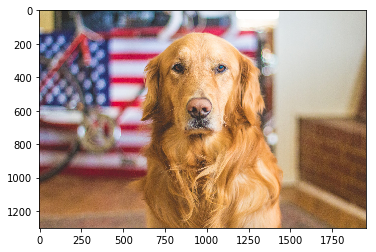

In [27]:
final_predict("samples/photo1.jpeg")

Correct.

It is a dog with breed Alaskan malamute.


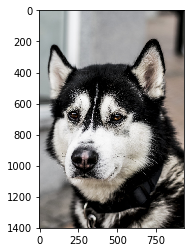

In [28]:
final_predict("samples/photo2.jpeg")

Correct.

It is a dog with breed Golden retriever.


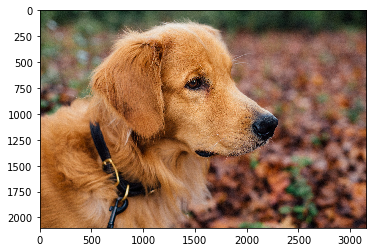

In [29]:
final_predict("samples/photo3.jpeg")

Correct.

It is a dog with breed Brussels griffon.


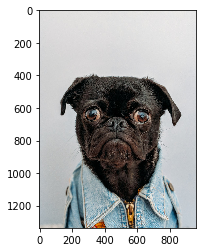

In [30]:
final_predict("samples/photo4.jpeg")

False.

It is a dog with breed Collie.


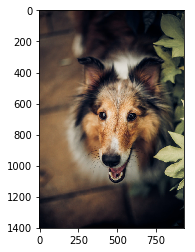

In [31]:
final_predict("samples/photo5.jpeg")

Correct.